In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

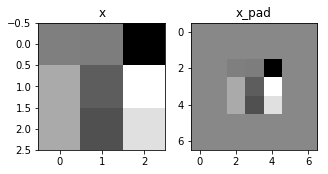

In [10]:
# 填充

def zero_pad(X, pad):
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values = (0, 0))
    return X_pad

x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)

plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest' # 最近邻插值
plt.rcParams['image.cmap'] = 'gray'

fig, ax = plt.subplots(1, 2)
ax[0].set_title('x')
ax[0].imshow(x[0, :, :, 0])
ax[1].set_title('x_pad')
ax[1].imshow(x_pad[0, :, :, 0])

In [24]:
# 卷积层

def conv_single_step(a_slice_prev, W, b): # 单步卷积
    s = np.multiply(a_slice_prev, W) + b
    Z = np.sum(s)
    
    return Z

def conv_forward(A_prev, W, b, hparameters): # 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    n_H = int((n_H_prev - f + 2*pad)/stride + 1)
    n_W = int((n_W_prev - f + 2*pad)/stride + 1)
    
    Z = np.zeros((m, n_H, n_W, n_C))
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h*stride # 垂直方向
                    vert_end = h*stride + f
                    horiz_start = w*stride #水平方向
                    horiz_end = w*stride + f
                    
                    a_slice_prev = A_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :] # 取出
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:, :, :, c]) # 卷积
                    
    cache = (A_prev, W, b, hparameters) 

    return Z, cache

def conv_backward(dZ, cache):
    
    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h*stride
                    vert_end = h*stride + f
                    horiz_start = w*stride
                    horiz_end = w*stride + f
                    
                    a_slice = A_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :]
                    dA_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = dA_prev_pad[i, pad:-pad, pad:-pad, :]
    
    return dA_prev, dW, db

In [22]:
# 池化层

def pool_forward(A_prev, hparameters, mode = "max"):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters['f']
    stride = hparameters['stride']
    
    n_H = int((n_H_prev - f)/stride + 1)
    n_W = int((n_W_prev - f)/stride + 1)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h*stride 
                    vert_end = h*stride + f
                    horiz_start = w*stride 
                    horiz_end = w*stride + f
                    
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    if mode == 'max':
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == 'average':
                        A[i, h, w, c] = np.mean(a_prev_slice)
                        
    cache = (A_prev, hparameters)
    
    return A, cache

def create_mask_from_window(x):
    
    mask = (x == np.max(x))
    
    return mask

def distribute_value(dz, shape):
    
    (n_H, n_W) = shape
    average = dz / (n_H * n_W)
    
    a = np.ones((n_H, n_W)) * average
    
    return a

def pool_backward(dA, cache, mode = "max"):
    
    (A_prev, hparameters) = cache
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    (m, n_H_prev, n_W_prev, n_C_prev)= A_prev.shape
    (m, n_H, n_W, n_C) = dA.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = stride*h
                    vert_end = stride*h + f
                    horiz_start = stride*w
                    horiz_end = stride*w + f
                    
                    if mode == "max":
                        a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask*dA[i, h, w, c]
                    
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                        
    return dA_prev

In [23]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
